# NeuroBoostedTrees

This notebook illustrates the analyses presented in the following paper:
"Resolving neuronal population code and  coordination with gradient boosted trees, Viejo et al, 2017"

We made an extensive use of [XGBoost][3] for analysing head-direction data.

This work is the follow-up of a previously published paper: "[Modern machine learning far outperforms GLMs at predicting spikes, Benjamin et al, 2017][2]".

The dataset for this tutorial can be found [here.][1]

We present two of our analyses: prediction scoring of spiking activity in relation to behaviour and dissectiong of the gradient boosted tree branching after learning (i.e. the splitting positions and gains). All the Python code used for the manuscript can be found [here][4] (or you can send us a message). Sorry, still a bit messy, but we're working on it! 

 
## Table of content

I. Predicting firing rate as a function of head-direction
    1. Loading data
    2. Integrating data into Panda framework
    3. Prediction score functions and cross validations
    4. Definitions of the learners
    5. Supervised learning
    
II. Analysing the tree structure
    1. Extracting tree threshold from XGB
    2. Learning XGB examples
    3. Tuning curves
    4. Extracting tree structure
    5. Correlation with Fisher Information
    
III. Miscellaneous
    1. Computing the gain    
    
## Dependencies

Basics
 - matplotlib
 - numpy
 - pandas
 - scipy
 - warnings
 - itertools
 
Methods
 - xgboost
 

[1]:www.peyrachelab.com/data/data_test_boosted_tree_20ms.mat
[2]:http://biorxiv.org/content/early/2017/02/24/111450
[3]:http://xgboost.readthedocs.io/en/latest/
[4]:https://github.com/gviejo/Prediction_xgb_head_direction

In [1]:
import warnings
import pandas as pd
import scipy.io
import numpy as np
import sys, os
import itertools



## I. Predicting firing rate as a function of head-direction

### 1. Loading data

First, a dictionnary of array is loaded.
Keys are :
    - 'Ang'   : head-direction (an angular value)
    - 'X'     : x position 
    - 'Y'     : y position
    - 'ADn'   : Antero-dorsal nucleus spiking activity (17 neurons)
    - 'Pos'   : Post-subiculum spiking activity (15 neurons)
    - 'speed' : animal speed

In [2]:
#head direction data
hd_data = scipy.io.loadmat('../python/data_test_boosted_tree_20ms.mat') # 20 ms is the size of the time bin
print(hd_data.keys())


['Ang', 'Pos', '__header__', '__globals__', 'ADn', 'Y', 'X', '__version__', 'speed']


### 2. Integrating data into Panda framework

Pandas makes life much easier when dealing with different subgroups of features. It allows to retrieve quickly time series.
Neurons are ordered based on their tuning curves (from 0 to 2pi). In Pandas, their name reflects their order ['ADn.0', 'ADn.1', 'ADn.2', ...].


In [3]:
data            =   pd.DataFrame()
data['time']    =   np.arange(len(hd_data['Ang']))     
data['ang']     =   hd_data['Ang'].flatten()            
data['x']       =   hd_data['X'].flatten()              
data['y']       =   hd_data['Y'].flatten()              
data['vel']     =   hd_data['speed'].flatten()
# neurons activity 
for i in xrange(hd_data['Pos'].shape[1]): data['Pos'+'.'+str(i)] = hd_data['Pos'][:,i]
for i in xrange(hd_data['ADn'].shape[1]): data['ADn'+'.'+str(i)] = hd_data['ADn'][:,i]

print data.keys()

Index([u'time', u'ang', u'x', u'y', u'vel', u'Pos.0', u'Pos.1', u'Pos.2',
       u'Pos.3', u'Pos.4', u'Pos.5', u'Pos.6', u'Pos.7', u'Pos.8', u'Pos.9',
       u'Pos.10', u'Pos.11', u'Pos.12', u'Pos.13', u'Pos.14', u'ADn.0',
       u'ADn.1', u'ADn.2', u'ADn.3', u'ADn.4', u'ADn.5', u'ADn.6', u'ADn.7',
       u'ADn.8', u'ADn.9', u'ADn.10', u'ADn.11', u'ADn.12', u'ADn.13',
       u'ADn.14', u'ADn.15', u'ADn.16'],
      dtype='object')


### 3. Prediction score functions and cross validations

This section requires Scikit-learn.


In [4]:
from sklearn.model_selection import KFold

def poisson_pseudoR2(y, yhat, ynull):
    """ Compute the pseudo R2 score
        y : real firing rate
        yhat : predicted firing rate
        ynull : mean of the real firing rate
    """    
    yhat = yhat.reshape(y.shape)
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm, n_cv=10):
    """Performs cross-validated fitting. Returns (Y_hat, pR2_cv); a vector of predictions Y_hat with the
    same dimensions as Y, and a list of pR2 scores on each fold pR2_cv.
    X  = input data
    Y = spiking data
    algorithm = a function of (Xr, Yr, Xt) {training data Xr and response Yr and testing features Xt}
                and returns the predicted response Yt
    n_cv = number of cross-validations folds
    """
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))
    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]           
        Yt_hat = eval(algorithm)(Xr, Yr, Xt)        
        Y_hat[idx_t] = Yt_hat
        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

    return Y_hat, pR2_cv


### 4. Definitions of learners

As in the paper, we define :
    - xgb_run  : XGBoost 
    - mb       : the model-based tuning curves of the neuron
    - lin_comb : a simple linear regression
    - kernel   : the kernel model that transforms the angular feature into a combination of cosinus and sinus (and their harmonics)

In [5]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression

def xgb_run(Xr, Yr, Xt):
    """ XGBoost model
        Return the predicted firing rate
    """
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "poisson-nloglik", #loglikelihood loss
    'seed': 2925,
    'silent': 1,
    'learning_rate': 0.1,
    'min_child_weight': 2, 
    # 'subsample': 0.6, 
    'max_depth': 5, 
    'gamma': 0.5
    }    
    dtrain = xgb.DMatrix(Xr, label=Yr)
    dtest = xgb.DMatrix(Xt)
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    Yt = bst.predict(dtest)
    return Yt

def mb(Xr, Yr, Xt):
    """ Compute the model-based tuning curve of the hd cells
        And return the predicted firing rate        
    """
    nb_bins = 60
    bins = np.linspace(np.vstack((Xr, Xt)).min(), np.vstack((Xr, Xt)).max()+1e-8, nb_bins+1)
    index = np.digitize(Xr, bins).flatten()    
    tcurve = np.array([np.sum(Yr[index == i]) for i in xrange(1, nb_bins+1)])
    occupancy = np.array([np.sum(index == i) for i in xrange(1, nb_bins+1)])
    tcurve = (tcurve/occupancy)*40.0  
    new_index = np.digitize(Xt, bins).flatten()    
    return tcurve[new_index-1]/40.0 

def lin_comb(Xr, Yr, Xt):
    """ Linear model
        Return the predicted firing rate
    """
    lr = LinearRegression()
    lr.fit(Xr, Yr)
    Yt = lr.predict(Xt)    
    #rectify outputs
    Yt = np.maximum(Yt,np.zeros(Yt.shape))
    return Yt 

def kernel(Xr, Yr, Xt):
    """ Kernel model, cos and sin of the angle to the linear model
        Return the predicted firing rate
    """
    newX = np.zeros((Xr.shape[0], 12)) # up to six order    
    newXt = np.zeros((Xt.shape[0], 12))
    for i, j in zip(xrange(1,7), xrange(0, 12, 2)):
        newX[:,j] = np.cos(i*Xr).flatten()
        newX[:,j+1] = np.sin(i*Xr).flatten()
        newXt[:,j] = np.cos(i*Xt).flatten()
        newXt[:,j+1] = np.sin(i*Xt).flatten()
    Yt = lin_comb(newX, Yr, newXt)    
    return Yt

### 5 Supervised learning

The function test_features takes as argument a list of features and targets and runs the supervised learning procedure using cross-validation.


In [6]:
def test_features(features, targets, learners):
    '''
    features : a list of features, for example ['ang', 'x', 'y']
    targets :  the list of neurons to predict ['ADn.0', 'ADn.1']
    learners : the list of model to use, for example ['xgb']        
    Return : dictionnary with for each models the score PR2 and Yt_hat (the prediction of the firing rate)
    '''
    X = data[features].values
    Y = data[targets].values    
    output = {method:{'PR2':[],'Yt_hat':[]} for method in learners}
    learners_ = list(learners)
    for i in xrange(Y.shape[1]):
        y = Y[:,i]        
        for method in learners_:        
            print('Running '+method+' to predict '+targets[i])                              
            Yt_hat, PR2 = fit_cv(X, y, algorithm = method, n_cv=8)       
            output[method]['Yt_hat'].append(Yt_hat)
            output[method]['PR2'].append(PR2)           
    for m in output.iterkeys():
        output[m]['Yt_hat'] = np.array(output[m]['Yt_hat'])
        output[m]['PR2'] = np.array(output[m]['PR2'])        
    return output
    

 The combinations to be learned are defined here in a dictionnary.

In [7]:
combination = {
    'Pos':  {
            'features'  :   ['ang'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'Pos'], 
            },          
    'ADn':  {
            'features'  :   ['ang'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'ADn'],
            }
}
print(combination['ADn'])
print(combination['Pos'])


{'features': ['ang'], 'targets': ['ADn.0', 'ADn.1', 'ADn.2', 'ADn.3', 'ADn.4', 'ADn.5', 'ADn.6', 'ADn.7', 'ADn.8', 'ADn.9', 'ADn.10', 'ADn.11', 'ADn.12', 'ADn.13', 'ADn.14', 'ADn.15', 'ADn.16']}
{'features': ['ang'], 'targets': ['Pos.0', 'Pos.1', 'Pos.2', 'Pos.3', 'Pos.4', 'Pos.5', 'Pos.6', 'Pos.7', 'Pos.8', 'Pos.9', 'Pos.10', 'Pos.11', 'Pos.12', 'Pos.13', 'Pos.14']}


- The main loop

In [8]:
methods = ['mb', 'xgb_run', 'lin_comb', 'kernel']
final_data = {}
for g in np.sort(combination.keys()):
    features = combination[g]['features']
    targets = combination[g]['targets'] 
    results = test_features(features, targets, methods)        
    final_data[g] = results
    

Running mb to predict ADn.0
Running xgb_run to predict ADn.0
Running lin_comb to predict ADn.0
Running kernel to predict ADn.0
Running mb to predict ADn.1
Running xgb_run to predict ADn.1
Running lin_comb to predict ADn.1
Running kernel to predict ADn.1
Running mb to predict ADn.2
Running xgb_run to predict ADn.2
Running lin_comb to predict ADn.2
Running kernel to predict ADn.2
Running mb to predict ADn.3
Running xgb_run to predict ADn.3
Running lin_comb to predict ADn.3
Running kernel to predict ADn.3
Running mb to predict ADn.4
Running xgb_run to predict ADn.4
Running lin_comb to predict ADn.4
Running kernel to predict ADn.4
Running mb to predict ADn.5
Running xgb_run to predict ADn.5
Running lin_comb to predict ADn.5
Running kernel to predict ADn.5
Running mb to predict ADn.6
Running xgb_run to predict ADn.6
Running lin_comb to predict ADn.6
Running kernel to predict ADn.6
Running mb to predict ADn.7
Running xgb_run to predict ADn.7
Running lin_comb to predict ADn.7
Running kernel t

- Let's plot the result for this dataset

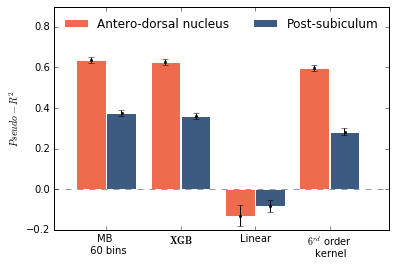

In [9]:
from matplotlib.pyplot import *

methods_to_plot = ['mb', 'xgb_run', 'lin_comb', 'kernel']
labels = {  'mb':'MB \n 60 bins', 
            'lin_comb':'Linear', 
            'nn':'NN', 
            'xgb_run':"$\mathbf{XGB}$",
            'h1':"Linear \n (cos$\\theta$, sin$\\theta$)",
            'kernel':"$6^{rd}$ order \n kernel"}
labels_plot = [labels[m] for m in methods_to_plot]
mean_pR2 = list()
sem_pR2 = list()
for model in methods_to_plot:
    PR2_art = final_data['ADn'][model]['PR2']
    mean_pR2.append(np.mean(PR2_art))
    sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))        
bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.4, align='center',
        ecolor='k', alpha=1, color='#EE6C4D', ec='w', yerr=np.array(sem_pR2), label = 'Antero-dorsal nucleus')
plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=5)
mean_pR2 = list()
sem_pR2 = list()
for model in methods_to_plot:
    PR2_art = final_data['Pos'][model]['PR2']
    mean_pR2.append(np.mean(PR2_art))
    sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))
bar(np.arange(np.size(mean_pR2))+0.405, mean_pR2, 0.4, align='center',
        ecolor='k', alpha=1, color='#3D5A80', ec='w', yerr=np.array(sem_pR2), label = 'Post-subiculum')
plot(np.arange(np.size(mean_pR2))+0.41, mean_pR2, 'k.', markersize=5)
plot([-1, len(methods_to_plot)], [0,0],'--k', alpha=0.4)
legend(loc='upper center', ncol=2, frameon = False)
xlim(-0.5,)
ylim(-0.2, 0.9)
xticks(np.arange(np.size(mean_pR2))+0.205, labels_plot)
ylabel("$Pseudo-R^2$")

show()

## II. ANALYSING SPLIT POSITIONS

Using the same dataset, we will now look at the positions of splits within the tuning curve of one neuron from ADn and one neuron from PoSub.

### 1. Extracting tree thresholds from XGB

By default, XGB returns a list of tree as strings. To extract the split positions, one needs to parse the string first. That is the purpose of the function extract_tree_threshold that takes as input the booster. 
Here, we also define fisher_information which takes as input the tuning curve.

This section requires graphviz.



In [10]:
def extract_tree_threshold(trees):
    """ Take BST TREE and return a dict = {features index : [splits position 1, splits position 2, ...]}
    """
    n = len(trees.get_dump())
    thr = {}
    for t in xrange(n):
        gv = xgb.to_graphviz(trees, num_trees=t)
        body = gv.body		
        for i in xrange(len(body)):
            for l in body[i].split('"'):
                if 'f' in l and '<' in l:
                    tmp = l.split("<")
                    if thr.has_key(tmp[0]):
                        thr[tmp[0]].append(float(tmp[1]))
                    else:
                        thr[tmp[0]] = [float(tmp[1])]
    for k in thr.iterkeys():
        thr[k] = np.sort(np.array(thr[k]))
    return thr


def fisher_information(x, f):
    """ Compute Fisher Information over the tuning curves
        x : array of angular position
        f : firing rate
        return (angular position, fisher information)
    """
    fish = np.zeros(len(f)-1)
    slopes_ = []
    tmpf = np.hstack((f[-1],f,f[0:3]))
    binsize = x[1]-x[0]	
    tmpx = np.hstack((np.array([x[0]-binsize-(x.min()+(2*np.pi-x.max()))]),x,np.array([x[-1]+i*binsize+(x.min()+(2*np.pi-x.max())) for i in xrange(1,4)])))		
    for i in xrange(len(f)):
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tmpx[i:i+3], tmpf[i:i+3])
        slopes_.append(slope)
    fish = np.power(slopes_, 2)
    fish = fish/(f+1e-4)
    return (x, fish)


Let's define new combinations.

In [11]:
combination = {
    'ang':{
        'ADn':{
            'features' 	:	['ang'],
            'targets'	:	['ADn.8']
                },
        'Pos':	{
            'features' 	:	['ang'],
            'targets'	:	['Pos.9']
                },
        },
    }

### 2. Learning XGB examples

Each booster is saved in the dictionnary bsts.

In [12]:
params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.01,
    'min_child_weight': 2,
    'max_depth': 5}        

num_round = 30
bsts = {}
for i in combination.iterkeys():    
    bsts[i] = {}
    for j in combination[i].iterkeys():        
        features = combination[i][j]['features']
        targets = combination[i][j]['targets']
        print("Learning "+targets[0]+" from feature "+features[0])
        X = data[features].values
        Yall = data[targets].values
        for k in xrange(Yall.shape[1]):
            dtrain = xgb.DMatrix(X, label=Yall[:,k])
            bst = xgb.train(params, dtrain, num_round)
            bsts[i][j] = bst

print(bsts.keys())

Learning ADn.8 from feature ang
Learning Pos.9 from feature ang
['ang']


### 3. Tuning curves

By default, tuning curves are built over 60 angular bins.

In [13]:
def tuning_curve(x, f, nb_bins, tau = 40.0):
    bins = np.linspace(x.min(), x.max()+1e-8, nb_bins+1)
    index = np.digitize(x, bins).flatten()    
    tcurve = np.array([np.sum(f[index == i]) for i in xrange(1, nb_bins+1)])
    occupancy = np.array([np.sum(index == i) for i in xrange(1, nb_bins+1)])
    tcurve = (tcurve/occupancy)*tau
    x = bins[0:-1] + (bins[1]-bins[0])/2.
    return (x, tcurve)

X = data['ang'].values
example = [combination['ang'][k]['targets'][0] for k in ['ADn', 'Pos']]
tuningc = {}
for k in example:
    Y = data[k].values
    tuningc[k.split(".")[0]] = tuning_curve(X, Y, nb_bins = 60)
    


- Let's plot the two tuning curves.

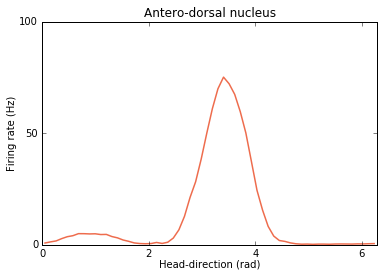

In [14]:

title_ = ['Antero-dorsal nucleus', 'Post-subiculum']
colors_ = ['#EE6C4D', '#3D5A80']
figure()
limts = [(1.5,5),(0.7, 3.6)]

e = 'ADn'
i = 0
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)
xlim(0, 2*np.pi)
    
show()

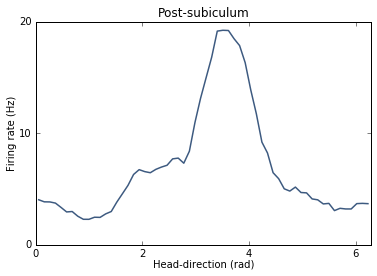

In [15]:
figure()
e = 'Pos'
i = 1
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)
xlim(0,2*np.pi)


show()

### 4. Extracting tree structure

HEre, 'thresholds' is the dictionnary that contains the position of splits for the only feature we use: f0 (the head-direction). However, the function is generic enough to take multi-dimensional bosster as argument (e.g. f0, f1, f2, ...).

In [16]:
thresholds = {}
for i in bsts.iterkeys():
    thresholds[i] = {}
    for j in bsts[i].iterkeys():
        thresholds[i][j] = extract_tree_threshold(bsts[i][j])

print(thresholds.keys())
print(thresholds['ang'].keys())
print(thresholds['ang']['ADn'].keys())
print(len(thresholds['ang']['Pos']['f0'])), "splits"


['ang']
['ADn', 'Pos']
['f0']
628 splits


- Let's plot the tuning curves and the splits.


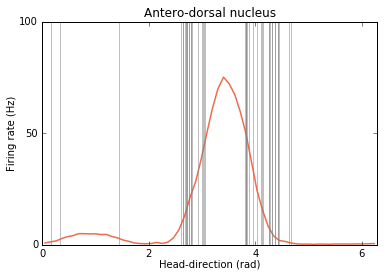

In [17]:
e = 'ADn'
i = 0
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)
xlim(0, 2*np.pi)

[axvline(l, alpha = 1, color = 'grey', linewidth = 0.5) for l in np.unique(thresholds['ang'][e]['f0'])]

show()

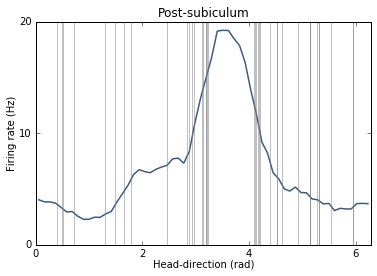

In [18]:
figure()
e = 'Pos'
i = 1
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)
xlim(0,2*np.pi)

[axvline(l, alpha = 1, color = 'grey', linewidth = 0.5) for l in np.unique(thresholds['ang'][e]['f0'])]


show()

### 5. Fisher Information

In [19]:
adn_fisher = fisher_information(tuningc['ADn'][0], tuningc['ADn'][1])
pos_fisher = fisher_information(tuningc['Pos'][0], tuningc['Pos'][1])



- Let's plot the Fisher information

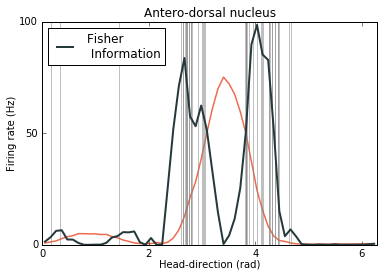

In [20]:
e = 'ADn'
i = 0
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)


[axvline(l, alpha = 1, color = 'grey', linewidth = 0.5) for l in np.unique(thresholds['ang'][e]['f0'])]

twinx()
plot(adn_fisher[0], adn_fisher[1], '-', color = '#25393C', label = 'Fisher \n Information', linewidth = 2.0)
yticks([])
xlim(0, 2*np.pi)
legend(loc = 'best')

show()

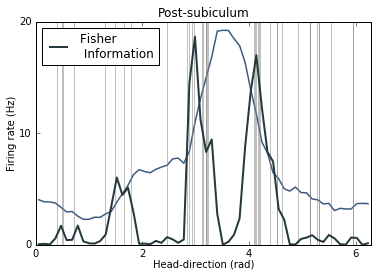

In [21]:
figure()
e = 'Pos'
i = 1
plot(tuningc[e][0], tuningc[e][1], color = colors_[i], linewidth = 1.5)
xlabel('Head-direction (rad)', labelpad = 0.0)
ylabel('Firing rate (Hz)', labelpad = 2.1)
locator_params(axis='y', nbins = 3)
locator_params(axis='x', nbins = 4)
title(title_[i], fontsize = 12)
xlim(0,2*np.pi)

[axvline(l, alpha = 1, color = 'grey', linewidth = 0.5) for l in np.unique(thresholds['ang'][e]['f0'])]

twinx()
plot(pos_fisher[0], pos_fisher[1], '-', color = '#25393C', label = 'Fisher \n Information', linewidth = 2.0)
yticks([])
xlim(0, 2*np.pi)
legend(loc = 'best')
show()

Et voila!

## III. Miscellaneous

### 1. Accessing the gain

By default, XGB returns the average gain over one feature for all the trees. By multiplying by the number of splits for each feature, you get the total gain.

- Let's define a new combination with head-direction and x,y positions and all the neurons from each group.

In [22]:
combination = {
    'ADn':    {
            'features'  :   ['ang', 'x', 'y'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'ADn']
        },
    'Pos':    {
            'features'  :   ['ang', 'x', 'y'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'Pos']
        },  
}
print combination

{'ADn': {'features': ['ang', 'x', 'y'], 'targets': ['ADn.0', 'ADn.1', 'ADn.2', 'ADn.3', 'ADn.4', 'ADn.5', 'ADn.6', 'ADn.7', 'ADn.8', 'ADn.9', 'ADn.10', 'ADn.11', 'ADn.12', 'ADn.13', 'ADn.14', 'ADn.15', 'ADn.16']}, 'Pos': {'features': ['ang', 'x', 'y'], 'targets': ['Pos.0', 'Pos.1', 'Pos.2', 'Pos.3', 'Pos.4', 'Pos.5', 'Pos.6', 'Pos.7', 'Pos.8', 'Pos.9', 'Pos.10', 'Pos.11', 'Pos.12', 'Pos.13', 'Pos.14']}}


- Let's learn the booster for each combination.

In [23]:
params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "poisson-nloglik", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.1,
    'min_child_weight': 2, 
    'n_estimators': 30,
    # 'subsample': 0.5, 
    'max_depth': 5, 
    'gamma': 0.5}        

num_round = 30
bsts = {}
for k in combination.keys():
    features = combination[k]['features']
    targets = combination[k]['targets'] 
    X = data[features].values
    Yall = data[targets].values 
    bsts[k] = {}
    for i in xrange(Yall.shape[1]):
        print k, targets[i]
        dtrain = xgb.DMatrix(X, label=Yall[:,i])
        bst = xgb.train(params, dtrain, num_round)
        bsts[k][targets[i]] = bst


ADn ADn.0
ADn ADn.1
ADn ADn.2
ADn ADn.3
ADn ADn.4
ADn ADn.5
ADn ADn.6
ADn ADn.7
ADn ADn.8
ADn ADn.9
ADn ADn.10
ADn ADn.11
ADn ADn.12
ADn ADn.13
ADn ADn.14
ADn ADn.15
ADn ADn.16
Pos Pos.0
Pos Pos.1
Pos Pos.2
Pos Pos.3
Pos Pos.4
Pos Pos.5
Pos Pos.6
Pos Pos.7
Pos Pos.8
Pos Pos.9
Pos Pos.10
Pos Pos.11
Pos Pos.12
Pos Pos.13
Pos Pos.14


- Let's retrieve the gain from the booster and plot for each features

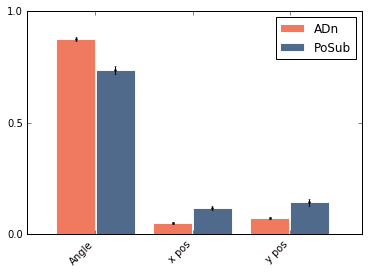

In [24]:
gain = {}
for i in ['ADn', 'Pos']:
    gain[i] = {}
    for j in bsts[i].iterkeys(): # for each neuron
        gain[i][j] = bsts[i][j].get_score(importance_type = 'gain')


labels = ['ADn', 'PoSub']
x = np.arange(3, dtype = float)
for g, i in zip(gain.iterkeys(), xrange(2)):
    tmp = []
    for k in gain[g].iterkeys():
        tmp.append([])
        for f in ['f0', 'f1', 'f2']:
            if f in gain[g][k].keys():
                tmp[-1].append(gain[g][k][f])
            else:
                tmp[-1].append(0.0)                
    tmp = np.array(tmp)
    tmp = tmp/np.vstack(tmp.sum(1))
    mean = tmp.mean(0)
    sem = np.std(tmp, 0)/np.sqrt(np.size(tmp))
    bar(x, mean, 0.4, yerr = sem, align='center',
        ecolor='k', alpha=.9, color=colors_[i], ec='w', label = labels[i], capsize = 1)
    plot(x, mean, 'o', alpha = 1, color = 'black', markersize = 2)
    x += 0.41
#     ylim(0,18)
    xlim(-0.5, 2.95)

xticks(np.arange(3)+0.205, ('Angle','x pos', 'y pos'), rotation = 45, ha='right')
locator_params(axis='y', nbins = 3)
legend()

show()

- Bonus : a function to extract the split order :

In [25]:
def extract_tree_order(trees, n_feat):
    # return array (len(trees), n_feat) 
    n = len(trees.get_dump())
    propor = np.zeros((n,n_feat))       
    for t in xrange(n):
        gv = xgb.to_graphviz(trees, num_trees=t)
        body = gv.body      
        for i in xrange(len(body)):
            for l in body[i].split('"'):
                if 'f' in l and '<' in l:
                    feat = l.split("<")[0]
                    propor[t,int(feat[1:])] += 1
    
    propor = np.cumsum(propor, 0)           
    propor = propor/np.vstack(np.sum(propor, 1))
    return propor